# Final Project: 2021년 국립국어원 인공지능 언어능력 평가

- [2021년 국립국어원 인공지능 언어능력 평가](https://corpus.korean.go.kr/task/taskList.do?taskId=1&clCd=END_TASK&subMenuId=sub01) 는 9월 1일부터 시작하여 11월 1일까지 마감된 [네 가지 과제에](https://corpus.korean.go.kr/task/taskDownload.do?taskId=1&clCd=END_TASK&subMenuId=sub02) 대한 언어능력 평가 대회
- 여기서 제시된 과제를 그대로 수행하여 그 결과를 [최종 선정된 결과들](https://corpus.korean.go.kr/task/taskLeaderBoard.do?taskId=4&clCd=END_TASK&subMenuId=sub04)과 비교할 수 있도록 수행
- 아직 테스트 셋의 정답이 공식적으로 공개되고 있지 않아, 네 가지 과제의 자료에서 evaluation dataset으로 가지고 성능을 비교할 계획
- 기말 발표전까지 정답셋이 공개될 경우 이 정답셋을 가지고 성능 검증
- Transformers 기반 방법론, 신경망 등 각자 생각한 방법대로 구현 가능
- 현재 대회기간이 종료되어 자료가 다운로드 가능하지 않으니 첨부된 자료 참조
- 개인적으로 하거나 최대 두명까지 그룹 허용. 
- 이 노트북 화일에 이름을 변경하여 작업하고 제출. 제출시 화일명을 FinalProject_[DS또는 CL]_학과_이름.ipynb
- 마감 12월 6일(월) 23:59분까지.
- 12월 7일, 9일 기말 발표 presentation 예정

## 리더보드

- 최종발표전까지 각조는 각 태스크별 실행성능을 **시도된 여러 방법의 결과들을 지속적으로**  [리더보드](https://docs.google.com/spreadsheets/d/1-uenfp5GolpY2Gf0TsFbODvj585IIiFKp9fvYxcfgkY/edit#gid=0)에 해당 팀명(구성원 이름 포함)을 입력하여 공개하여야 함. 
- 최종 마감일에 이 순위와 실제 제출한 프로그램의 수행 결과를 비교하여 성능을 확인

import package

In [1]:
import os
import math
import torch
import numpy as np
import pandas as pd
from torch import nn
from glob import glob
from tqdm import tqdm
from transformers import AdamW
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import matthews_corrcoef, accuracy_score
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 1. 문법성

In [2]:
# load data
train = pd.read_csv('./data//NIKL_CoLA_train.tsv', sep='\t')
dev = pd.read_csv('./data/NIKL_CoLA_dev.tsv', sep='\t')
test = pd.read_csv('./data/NIKL_CoLA_test.tsv', sep='\t')

In [3]:
def tokenized_dataset(dataset, tokenizer, arch="encoder"):
    sentence = dataset['sentence'].tolist()

    tokenized_sentences = tokenizer(
        sentence,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=37,
        add_special_tokens=True,
        return_token_type_ids = True
        )

    return tokenized_sentences

class CustomDataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.1, use_activation=True):
        super(FCLayer, self).__init__()
        self.use_activation = use_activation
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear(x)
        if self.use_activation:
            x = self.activation(x)
        return x

    
class Attention(nn.Module):
    def __init__(self, pretrained, dropout_rate):
        super(Attention, self).__init__()
        self.pretrained = pretrained
        self.classifier = nn.Sequential(
            FCLayer(256, 256, dropout_rate=dropout_rate),
            FCLayer(256, 256, dropout_rate=dropout_rate),
            FCLayer(256, 128, dropout_rate=dropout_rate),
            FCLayer(128, 2)
        )
        self.Q = nn.Linear(768,256)
        self.K = nn.Linear(768,256)
        self.V = nn.Linear(768,256)
    
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None):
        output = self.pretrained(input_ids=input_ids, attention_mask=attention_mask, 
                                 token_type_ids=token_type_ids)[0]
        
        d_k = self.K(output).size(-1)
        attention_score  = torch.matmul(self.Q(output), torch.transpose(self.K(output), 1, 2))
        attention_score = attention_score / math.sqrt(d_k)
        
        mask = torch.nan_to_num((attention_mask - 1) * np.inf, 0)
        attn_dim = attention_mask.shape[-1]
        mask = mask.repeat(1, attn_dim).reshape(-1, attn_dim, attn_dim)
        
        attention_score += mask
        score = F.softmax(attention_score, -1)
        output = torch.matmul(score, self.V(output))
        output = torch.mean(output, 1)
        output = self.classifier(output)
        return output

In [4]:
def training(train, dev, model_name, batch_size, num_epochs, learning_rate,
             saved_folder, drop_rate=0.2, load_model=None, fix=False):
    path = 'monologg/koelectra-base-v3-discriminator'
    warmup_ratio = 0.1
    if torch.cuda.is_available():
        device = torch.device("cuda:0")

    
    model = AutoModelForSequenceClassification.from_pretrained(path)
    tok = AutoTokenizer.from_pretrained(path)

    model = eval('%s(model.electra, drop_rate)' % model_name)
    
    if load_model is not None:
        model.load_state_dict(torch.load(load_model))
    
    # Freeze Parameter
    if fix:
        for name, param in model.named_parameters():
            if ('electra' in name):
                param.requires_grad = False
    
    tokenized_train = tokenized_dataset(train, tok)
    train_label = train['acceptability_label'].values

    tokenized_dev = tokenized_dataset(dev, tok)
    dev_label = dev['acceptability_label'].values

    train_dataset = CustomDataset(tokenized_train, train_label)
    dev_dataset = CustomDataset(tokenized_dev, dev_label)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    t_total = len(train_loader) * num_epochs
    warmup_step = int(t_total * warmup_ratio)
    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=warmup_step, 
                                                num_training_steps=t_total)

    model = model.to(device)


    for epoch in range(num_epochs):
        pbar = tqdm(train_loader, dynamic_ncols=True)

        model.train()
        train_pred = []
        train_y = []

        for idx, items in enumerate(pbar):
            item = {key: val.to(device) for key, val in items.items()}

            optimizer.zero_grad()
            outs = model(**item)
            loss = criterion(outs, item['labels'])

            preds = torch.argmax(outs, dim=-1)

            loss.backward()
            optimizer.step()
            scheduler.step()

            labels = items['labels'].cpu().detach().numpy().tolist()
            preds = preds.cpu().detach().numpy().tolist()
            train_pred += labels
            train_y += preds


        # val loop
        with torch.no_grad():
            model.eval()
            pbar = tqdm(dev_loader, dynamic_ncols=True)
            dev_pred = []
            dev_y = []


            for idx, items in enumerate(pbar):
                item = {key: val.to(device) for key, val in items.items()}
                outs = model(**item)
                preds = torch.argmax(outs, dim=-1)

                labels = items['labels'].cpu().detach().numpy().tolist()
                preds = preds.cpu().detach().numpy().tolist()
                dev_pred += labels
                dev_y += preds


        train_acc = accuracy_score(train_pred, train_y)
        dev_acc = accuracy_score(dev_pred, dev_y)
        train_mcc = matthews_corrcoef(train_pred, train_y)
        dev_mcc = matthews_corrcoef(dev_pred, dev_y)

        print('train')
        print('acc: %.4f, mcc: %.4f' % (train_acc, train_mcc))
        print('dev')
        print('acc: %.4f, mcc: %.4f' % (dev_acc, dev_mcc))


        os.makedirs(saved_folder, exist_ok=True)
        files = glob(os.path.join(saved_folder, '%s_%s*' % (path.split('/')[1], model_name)))

        if len(files) != 0:
            if np.max([float(f.split('_')[-1][:-3]) for f in files]) < dev_mcc:

                name = '%s_%s_%.6f.pt' % (path.split('/')[1], model_name, dev_mcc)
                torch.save(model.state_dict(), os.path.join(saved_folder, name))
        else:
            name = '%s_%s_%.6f.pt' % (path.split('/')[1], model_name, dev_mcc)
            torch.save(model.state_dict(), os.path.join(saved_folder, name))

In [5]:
def inference(dev, model_name, load_model=None):
    path = 'monologg/koelectra-base-v3-discriminator'
    warmup_ratio = 0.1
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        
    model = AutoModelForSequenceClassification.from_pretrained(path)
    tok = AutoTokenizer.from_pretrained(path)
    
    model = eval('%s(model.electra, 0)' % model_name)
    
    if load_model is not None:
        model.load_state_dict(torch.load(load_model))
    
    model = model.to(device)
    tokenized_dev = tokenized_dataset(dev, tok)
    dev_label = dev['acceptability_label'].values

    dev_dataset = CustomDataset(tokenized_dev, dev_label)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    
    
    # val loop
    with torch.no_grad():
        model.eval()
        pbar = tqdm(dev_loader, dynamic_ncols=True)
        dev_pred = []
        dev_y = []


        for idx, items in enumerate(pbar):
            item = {key: val.to(device) for key, val in items.items()}
            outs = model(**item)
            preds = torch.argmax(outs, dim=-1)

            labels = items['labels'].cpu().detach().numpy().tolist()
            preds = preds.cpu().detach().numpy().tolist()
            dev_pred += labels
            dev_y += preds

    dev_acc = accuracy_score(dev_pred, dev_y)
    dev_mcc = matthews_corrcoef(dev_pred, dev_y)

    print('dev')
    print('acc: %.4f, mcc: %.4f' % (dev_acc, dev_mcc))

In [6]:
model_name = 'Attention'

# hyperparameters
batch_size = 256
num_epochs = 100
learning_rate =  0.00002
warmup_ratio = 0.1
saved_folder = 'saved_model'

In [8]:
training(train, dev, 'Attention', batch_size, num_epochs, learning_rate, 
         saved_folder, fix=False, load_model=None, drop_rate=0.5)

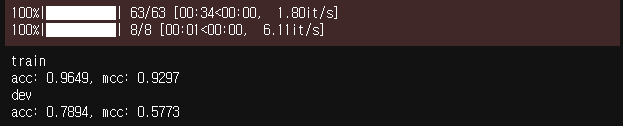

# Inference

In [7]:
load_model = 'saved_model/문법성_0.577342.pt'
inference(dev, 'Attention', load_model)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

dev
acc: 0.7894, mcc: 0.5773


# 2. 동형이의어구별

## Convert Training Data (csv to jsonl)

In [10]:
import torch
from torch import nn
from torch import optim
import os
import string
import copy
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import json
import collections
import transformers
import pandas as pd
import random
import array
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, AutoModelWithLMHead, AutoModelForPreTraining
from transformers import ElectraModel, ElectraTokenizer

In [1]:
my_path = '../dataset/2. 동형이의어구별'

In [19]:
import pandas as pd

df_train = pd.read_csv(f'{my_path}/NIKL_SKT_WiC_Train.tsv', sep="\t")
df_val = pd.read_csv(f'{my_path}/NIKL_SKT_WiC_Dev.tsv', sep="\t")
df_test = pd.read_csv(f'{my_path}/NIKL_SKT_WiC_Test.tsv', sep="\t")

In [179]:
df_train

,ID,Target,SENTENCE1,SENTENCE2,ANSWER,start_s1,end_s1,start_s2,end_s2
0,1,단정,그의 죽음은 타살로 단정이 되었다.,단정이 된 교실은 정돈되어 있다.,False,11,13,0,2
1,2,단수,현대 생활에서 단전과 단수의 고통은 겪어 보지 않으면 짐작도 못한다.,사업자를 단수로 할지 복수로 할지를 놓고 관계자들 사이에 입씨름이 벌어졌다.,False,12,14,5,7
2,3,화성,"화성은 밤과 낮, 하루의 길이와 계절의 변화가 지구와 매우 비슷하다.",화성은 서양 음악을 이루는 중요한 요소이다.,False,0,2,0,2
3,4,자전,달의 자전 주기는 달이 지구의 둘레를 공전하는 주기와 같다.,태양계의 모든 행성은 자전을 한다.,True,3,5,12,14
4,5,동지,오늘의 적이 내일은 동지가 될 수 있다.,동지에 무와 감자를 나누어 심었다.,False,11,13,0,2
...,...,...,...,...,...,...,...,...,...
7743,7744,맞,고 노무현 전 대통령의 딸 정연 씨가 25일 “2009년 미국 아파트 원주인인 경연...,최루탄 머리 맞고 9개월 혼수상태… ‘터키 민주화시위 상징’으로 떠올라,False,100,101,7,8
7744,7745,뜨,"아들은 ""50년 넘게 집에서만 지내신 어머니가 이번에야말로 눈을 뜨면 좋겠다""고 기...",“안철수 원장이 정치권에서 뜨는 것은 사회적으로 잘못된 것이다.”(심대평 자유선진당...,False,36,37,15,16
7745,7746,보였,"시내 대부분은 폐허가 됐고, 무너지지 않은 호텔은 이미 방이 꽉 차 있어 마땅히 숙...",양원준(41·사진) 복지TV 기획팀장이 오른쪽 와이셔츠 소매를 걷어올리자 100원짜...,True,77,79,58,60
7746,7747,불리,미방위원인 최민희 새정치연합 의원은 언론개혁시민연대와 함께 국회에서 기자회견을 열어...,‘축구 종가’ 잉글랜드의 안방으로 ‘축구의 성지’로 불리는 웸블리구장은 9만 관중을...,False,94,96,29,31


In [20]:
# 편의를 위해 영어 WiC 데이터와 같은 이름으로
# ID -> idx로는 안 바꿈
df_list = [df_train, df_val, df_test]

for df in df_list:
    df.rename(columns = {'Target':'word', 
                         'SENTENCE1':'sentence1',
                         'SENTENCE2':'sentence2',
                         'ANSWER':'label',
                         'start_s1':'start1',
                         'start_s2':'start2',
                         'end_s1':'end1',
                         'end_s2':'end2'}, inplace = True)

In [21]:
df_train

,ID,word,sentence1,sentence2,label,start1,end1,start2,end2
0,1,단정,그의 죽음은 타살로 단정이 되었다.,단정이 된 교실은 정돈되어 있다.,False,11,13,0,2
1,2,단수,현대 생활에서 단전과 단수의 고통은 겪어 보지 않으면 짐작도 못한다.,사업자를 단수로 할지 복수로 할지를 놓고 관계자들 사이에 입씨름이 벌어졌다.,False,12,14,5,7
2,3,화성,"화성은 밤과 낮, 하루의 길이와 계절의 변화가 지구와 매우 비슷하다.",화성은 서양 음악을 이루는 중요한 요소이다.,False,0,2,0,2
3,4,자전,달의 자전 주기는 달이 지구의 둘레를 공전하는 주기와 같다.,태양계의 모든 행성은 자전을 한다.,True,3,5,12,14
4,5,동지,오늘의 적이 내일은 동지가 될 수 있다.,동지에 무와 감자를 나누어 심었다.,False,11,13,0,2
...,...,...,...,...,...,...,...,...,...
7743,7744,맞,고 노무현 전 대통령의 딸 정연 씨가 25일 “2009년 미국 아파트 원주인인 경연...,최루탄 머리 맞고 9개월 혼수상태… ‘터키 민주화시위 상징’으로 떠올라,False,100,101,7,8
7744,7745,뜨,"아들은 ""50년 넘게 집에서만 지내신 어머니가 이번에야말로 눈을 뜨면 좋겠다""고 기...",“안철수 원장이 정치권에서 뜨는 것은 사회적으로 잘못된 것이다.”(심대평 자유선진당...,False,36,37,15,16
7745,7746,보였,"시내 대부분은 폐허가 됐고, 무너지지 않은 호텔은 이미 방이 꽉 차 있어 마땅히 숙...",양원준(41·사진) 복지TV 기획팀장이 오른쪽 와이셔츠 소매를 걷어올리자 100원짜...,True,77,79,58,60
7746,7747,불리,미방위원인 최민희 새정치연합 의원은 언론개혁시민연대와 함께 국회에서 기자회견을 열어...,‘축구 종가’ 잉글랜드의 안방으로 ‘축구의 성지’로 불리는 웸블리구장은 9만 관중을...,False,94,96,29,31


In [22]:
# jsonl 파일로 저장
df_train.to_json(f'{my_path}/WiC_train.jsonl', orient='records', lines=True, force_ascii = False)
df_val.to_json(f'{my_path}/WiC_val.jsonl', orient='records', lines=True, force_ascii = False)
df_test.to_json(f'{my_path}/WiC_test.jsonl', orient='records', lines=True, force_ascii = False)

## Choose Pretrained Model

In [3]:
# klue/bert-base
# model = AutoModel.from_pretrained("klue/bert-base")
# model_name = 'BERT-base'
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

# klue/roberta-base
# model = AutoModel.from_pretrained("klue/roberta-base")
# model_name = 'RoBERTa-base'
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")

# klue/roberta-large
# model = AutoModel.from_pretrained("klue/roberta-large")
# model_name = 'RoBERTa-large'
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# monlogg/koelectra-base-v2-discriminator
# model = ElectraModel.from_pretrained("monologg/koelectra-base-v2-discriminator")
# model_name = 'KoELECTRA-base-v2-dis'
# tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v2-discriminator")

# monlogg/koelectra-base-v3-discriminator
# model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
# model_name = 'KoELECTRA-base-v3-dis'
# tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

# tunib/electra-ko-base
model = AutoModel.from_pretrained('tunib/electra-ko-base')
model_name = 'KoELECTRA-base'
tokenizer = AutoTokenizer.from_pretrained('tunib/electra-ko-base')

Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Tokenizer 체크 (앞뒤에 CLS, SEP 있는지)
print(tokenizer.encode("가"))
print(tokenizer.encode("여행을 떠나자"))

[2, 128, 3]
[2, 13843, 13012, 6044, 3]


## Parameters

In [5]:
#Determine how many elements we want to train during each iteration
BATCH_SIZE = 32
EPOCHS = 20
PATIENCE = 10

# Prepare Torch to use GPU, and use CPU when it's not available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
# n_gpu = torch.cuda.device_count()

#Get the GPU device name
torch.cuda.get_device_name(1)

'NVIDIA TITAN V'

## Functions

In [6]:
#Readfile function to take all the objects out of jsonl files
def parse_file_to_JSON(filename):
    serparated_json_objs = []
    
    #grab each line and add it as an element in json objs arr
    with open(filename, mode = "r") as jsonl_file:
        for i in jsonl_file:
            serparated_json_objs.append(json.loads(i))

    return serparated_json_objs

#Take a list of words (strings) and a sentence and returns a list
#of pairs indicating the tokens' start and end positions in the sentence for each word
#Create a function that matches word in tokenized sentence
def find_word_in_tokenized_sentence(word,token_ids):
    
    # decomposedWord = tokenizer.encode(word)
    decomposedWord = tokenizer.encode(word)[1:-1] # 수정함
    
    # print('decomposedWord:', decomposedWord) # 추가함
   #Iterate through to find a matching sublist of the token_ids
    for i in range(len(token_ids)):
        if token_ids[i] == decomposedWord[0] and token_ids[i:i+len(decomposedWord)] == decomposedWord:
            return (i,i+len(decomposedWord)-1)
    #finalize the output if there is no matching pattern found
    # print('returned -1 -1') # 추가함
    return (-1,-1)
  
def find_words_in_tokenized_sentences(wordList,token_ids):
    #Create a intList that marks the positions of words
    intList = []
    #if intList is empty, call the previous function as no matching pattern found
    for word in wordList:
        if len(intList) == 0:
            intList.append(find_word_in_tokenized_sentence(word,token_ids))
        else:
            afterLastInterval = intList[-1][1]+1
            interv = find_word_in_tokenized_sentence(word,token_ids[afterLastInterval:])
            actualPositions = (interv[0] + afterLastInterval,interv[1]+afterLastInterval)
            intList.append(actualPositions)
    return intList

In [7]:
def preprocessing(json_objects, training = True):
    
    wic_sentences, wic_encoded, wic_labels, wic_word_locs, wic_indexes = [], [], [] ,[] ,[]
    
    for index, example in enumerate(json_objects):
        
        wic_indexes.append(index)
        sentence = f"<s>{example['sentence1']}</s><s>{example['sentence2']}</s>"
        wic_sentences.append(sentence)

        wic_encoded.append(tokenizer.encode(sentence))
        
        # locate word in context
        word = example['word']
        location_of_word = (-1, -1)
        sent1_split = example['sentence1'].split(' ')
        sent2_split = example['sentence2'].split(' ')
        
        # wic indx
        sent1_word_char_loc = (example['start1'], example['end1'])
        sent2_word_char_loc = (example['start2'], example['end2'])
        
        num_characters = 0
        
        i, j = 0, 0
        word1_not_found, word2_not_found = True, True
        
        #locate word one
        while word1_not_found and i < len(sent1_split):
            word_len = len(sent1_split[i])
            if num_characters >= sent1_word_char_loc[0] or num_characters + word_len >= sent1_word_char_loc[1]:
                location_of_word = (i, -1) # Found the word in the sentence
                word1_not_found = False
            elif num_characters > sent1_word_char_loc[1]:
                location_of_word = (i - 1, -1)
                word1_not_found = False
            else:
                num_characters += word_len + 1 
                i += 1
                
        #locate word two
        num_characters = 0
        
        while word2_not_found and j < len(sent2_split):
            word_len = len(sent2_split[j])
            if num_characters >= sent2_word_char_loc[0] or num_characters + word_len >= sent2_word_char_loc[1]:
                location_of_word = (i, j)
                word2_not_found = False
            elif num_characters > sent2_word_char_loc[1]:
                location_of_word = (i, j - 1)
                word2_not_found = False
            else:
                num_characters += word_len + 1
                j += 1
                
        # Now to find the word in the tokenized sentences
        word1 = sent1_split[location_of_word[0]].translate(str.maketrans('', '', string.punctuation)) #Remove punctuation (See https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string)
        word2 = sent2_split[location_of_word[1]].translate(str.maketrans('', '', string.punctuation)) #Remove punctuation
        # print('word1:', word1) # 추가함
        # print('word2:', word2) # 추가함
        token_word_locs = find_words_in_tokenized_sentences([word1, word2], wic_encoded[-1])
        # print('wic_encoded[-1]:', wic_encoded[-1]) # 추가함
        # print('token_word_locs:', token_word_locs) # 추가함
        # print() # 추가함
        wic_word_locs.append(token_word_locs)
        
        # Get the label if we expect it to be there
        if training:
            if example['label']:
                wic_labels.append(1)
            else:
                wic_labels.append(0)
                
    # Pad the sequences and find the encoded word location in the combined input
    max_len = np.array([len(ex) for ex in wic_encoded]).max()
    wic_padded = {"input_ids" : [], "attention_mask" : [], "token_type_ids" : [], "word1_locs": [], "word2_locs" : [], "index" : wic_indexes}
    for i in range(0, len(wic_encoded)):
        enc_sentence = wic_encoded[i]
        location_of_word = wic_word_locs[i]
        # Pad the sequences
        ex_len = len(enc_sentence)
        padded_sentence = enc_sentence.copy()
        padded_sentence.extend([0]*(max_len - ex_len))
        wic_padded["input_ids"].append(padded_sentence)
        padded_mask = [1] * ex_len
        padded_mask.extend([0]*(max_len - ex_len))
        wic_padded["attention_mask"].append(padded_mask)
        # Create the vector to get back the words
        token_word_locs = wic_word_locs[i]
        first_word_loc = []
        second_word_loc = []
        len_first_word = token_word_locs[0][1] - token_word_locs[0][0] + 1
        len_second_word = token_word_locs[1][1] - token_word_locs[1][0] + 1
        for j in range(0, max_len):
            if j >= token_word_locs[0][0] and j <= token_word_locs[0][1]:
                #Part of the first word
                first_word_loc.append(1.0 / len_first_word)
            else:
                first_word_loc.append(0.0)
            if j >= token_word_locs[1][0] and j <= token_word_locs[1][1]:
                #Part of the second word
                second_word_loc.append(1.0 / len_second_word)
            else:
                second_word_loc.append(0.0)
        #We want to append a [1, max_len] vector instead of a [max_len] vector so wrap in an array
        wic_padded["word1_locs"].append([first_word_loc])
        wic_padded["word2_locs"].append([second_word_loc])
        #token_type_ids is a mask that tells where the first and second sentences are
        token_type_id = []
        first_sentence = True
        sentence_start = True
        for token in padded_sentence:
            if first_sentence and sentence_start and token == 0:
                #Allows 0 at the start of the first sentence
                token_type_id.append(0)
            elif first_sentence and token > 0:
                if sentence_start:
                    sentence_start = False
                token_type_id.append(0)
            elif first_sentence and not sentence_start and token == 0:
                first_sentence = False
                #Start of second sentence
                token_type_id.append(1)
            else:
                #Second sentence
                token_type_id.append(1)
        wic_padded["token_type_ids"].append(token_type_id)
        
    if training:
        for_tensor = {"input_ids": wic_padded["input_ids"], "token_type_ids": wic_padded["token_type_ids"],"attention_mask": wic_padded["attention_mask"], "labels": wic_labels, "index" : wic_padded["index"],"word1_locs": wic_padded["word1_locs"], "word2_locs" : wic_padded["word2_locs"]}
    else:
        for_tensor = {"input_ids": wic_padded["input_ids"], "token_type_ids": wic_padded["token_type_ids"], "attention_mask": wic_padded["attention_mask"], "index" : wic_padded["index"], "word1_locs": wic_padded["word1_locs"], "word2_locs" : wic_padded["word2_locs"]}

    return for_tensor

## Import and Process Data

In [8]:
#Data processing
train_json_objs = parse_file_to_JSON(f'{my_path}/WiC_train.jsonl')
raw_train_set = preprocessing(train_json_objs)
print(len(raw_train_set["labels"])/BATCH_SIZE)

242.125


In [9]:
#This makes our training data set for the training loop
train_data = TensorDataset(
    torch.tensor(raw_train_set["input_ids"]).to(device),
    torch.tensor(raw_train_set["token_type_ids"]).to(device),
    torch.tensor(raw_train_set["attention_mask"]).to(device),
    torch.tensor(raw_train_set["labels"]).to(device),
    torch.tensor(raw_train_set["word1_locs"]).to(device),
    torch.tensor(raw_train_set["word2_locs"]).to(device),
    torch.tensor(raw_train_set["index"]).to(device)
)

#This makes the sampler and data loader for our training loop
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

In [10]:
#This loads the jsonl files and make json using the helper functions
test_json_objs = parse_file_to_JSON(f'{my_path}/WiC_test.jsonl')
valid_json_objs = parse_file_to_JSON(f'{my_path}/WiC_val.jsonl')

#This does the preprocessing step for our json objects
raw_test_set = preprocessing(test_json_objs, training = False)
raw_valid_set = preprocessing(valid_json_objs)

#These are out test and validation data sets to be used to get our final accuracy and our results
#for the test.jsonl file.
test_data = TensorDataset(
    torch.tensor(raw_test_set["input_ids"]).to(device),
    torch.tensor(raw_test_set["token_type_ids"]).to(device),
    torch.tensor(raw_test_set["attention_mask"]).to(device),
    torch.tensor(raw_test_set["word1_locs"]).to(device),
    torch.tensor(raw_test_set["word2_locs"]).to(device),
    torch.tensor(raw_test_set["index"]).to(device)
)
validation_data = TensorDataset(
    torch.tensor(raw_valid_set["input_ids"]).to(device),
    torch.tensor(raw_valid_set["token_type_ids"]).to(device),
    torch.tensor(raw_valid_set["attention_mask"]).to(device),
    torch.tensor(raw_valid_set["labels"]).to(device),
    torch.tensor(raw_valid_set["word1_locs"]).to(device),
    torch.tensor(raw_valid_set["word2_locs"]).to(device),
    torch.tensor(raw_valid_set["index"]).to(device)
)

#This makes the sampler and data loader for the end of our program
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

## Load Model

In [11]:
#Loading in model

class WiC_Head(torch.nn.Module):
    def __init__(self, specific_model, embedding_size = 768):
        """
        add a linear layer to take the distance between two 
        """
        super(WiC_Head, self).__init__()
        self.embedding_size = embedding_size
        self.embedder = specific_model
        self.linear_diff = torch.nn.Linear(embedding_size, 250, bias = True)
        self.linear_seperator = torch.nn.Linear(250, 2, bias = True)
        self.loss = torch.nn.CrossEntropyLoss()
        self.activation = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    def forward(self, input_ids=None, attention_mask=None, labels=None,
                word1_locs = None, word2_locs = None):
        """
        same parameters as RoBERTa forward adding two tensors for the location of the 2 words to compare them
        """
        batch_size = word1_locs.shape[0]
        # get the embeddings (numerical representation)
        embs = self.embedder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state # 수정함
        
        # The words from the sentences
        word1s = torch.matmul(word1_locs, embs).view(batch_size, self.embedding_size)
        word2s = torch.matmul(word2_locs, embs).view(batch_size, self.embedding_size)
        
        # seeing how different are the words by substracting the numbers that represent the words
        diff = word1s - word2s
        
        # Calculate outputs using activation
        layer1_results = self.activation(self.linear_diff(diff))
        logits = self.softmax(self.linear_seperator(layer1_results))
        outputs = logits
        
        # Calculate prediction label
        if labels is not None:
            loss = self.loss(logits.view(-1, 2), labels.view(-1))
            outputs = (loss, logits)
        return outputs

In [12]:
#The model to be used
class_model = WiC_Head(model, embedding_size = 768)

In [13]:
#Testing the accuracy of our model
def flat_accuracy(preds, labels, return_predict_correctness = False):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    if return_predict_correctness:
        return np.sum(pred_flat == labels_flat) / len(labels_flat), pred_flat == labels_flat
    else:
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Training

In [15]:
#Accuracy desired
MIN_ACCURACY = 0.99
REACHED_MIN_ACCURACY = False
best_weights = class_model.state_dict()
max_val_acc = (0, 0) # (accuracy, epoch)
#Put the model in the GPU
class_model.cuda(1)

# Loss Graph
train_losses = [None]
val_losses = [None]

#Optimizer: changing the weights to make the moder optimal
param_optimizer = list(class_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
#Optimizer comes from hugging bert models
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

#Storing accuracy and loss
fit_history = {"loss": [],  "accuracy": [], "val_loss": [], "val_accuracy": []}
epoch_number = 0
epoch_since_max = 0
continue_learning = True

#This loop goes through the training process for each of the epochs
while epoch_number < EPOCHS and continue_learning:
    epoch_number += 1
    print(f"Training epoch #{epoch_number}")
    #Tracking variables
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    #Set the model to training mode so we can train it
    class_model.train()
    #Set the final weights
    class_model.embedder.requires_grad_ = False
    
    #This for loop goes through each of the batches in the epochs for training 
    #This loop trains each batch
    for step, batch in enumerate(train_dataloader):
        #Use the GPU to train the batch
        batch = tuple(t.cuda(1) for t in batch)
        #Get the items to be used from the data loader
        b_input_ids, b_token_ids, b_input_mask, b_labels, b_word1, b_word2, b_index = batch
        #Clear out the gradients
        optimizer.zero_grad()
        #Forward training
        loss, logits = class_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels, word1_locs = b_word1, word2_locs = b_word2) 
        #Backward training
        loss.backward()
        #Update parameters
        optimizer.step()
        #Update data to the CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        #Calculate the accuracy
        b_accuracy = flat_accuracy(logits, label_ids)
        #Append to fit history
        fit_history["loss"].append(loss.item()) 
        fit_history["accuracy"].append(b_accuracy) 
        #Update tracking variables
        tr_loss += loss.item()
        tr_accuracy += b_accuracy
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        #This prints the current batch's loss and accuracy
        # if nb_tr_steps%10 == 0:
        #     print("\t\tTraining Batch {}: Loss: {}; Accuracy: {}".format(nb_tr_steps, loss.item(), b_accuracy))
    print("Training:\n\tLoss: {}; Accuracy: {}".format(tr_loss/nb_tr_steps, tr_accuracy/nb_tr_steps))
    train_losses.append(tr_loss/nb_tr_steps)
    #Set model to evaluation mode so we can evaluate without training
    
    class_model.eval()
    #Evaluate data for one epoch
    for batch in validation_dataloader:
        #Add batch to GPU
        batch = tuple(t.cuda(1) for t in batch)
        #Unpack the inputs from our dataloader
        b_input_ids, b_token_ids, b_input_mask, b_labels, b_word1, b_word2, b_index = batch
        #not computing gradients
        with torch.no_grad():
            #Forward pass, calculate logit predictions
            loss, logits = class_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels, word1_locs = b_word1, word2_locs = b_word2)
        #Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        #Calculate the accuracy
        b_accuracy = flat_accuracy(logits, label_ids)
        #Append to fit history
        fit_history["val_loss"].append(loss.item())
        fit_history["val_accuracy"].append(b_accuracy) 
        #Update tracking variables
        eval_loss += loss.item()
        eval_accuracy += b_accuracy
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
        # if nb_eval_steps%10 == 0:
        #     print("\t\tValidation Batch {}: Loss: {}; Accuracy: {}".format(nb_eval_steps, loss.item(), b_accuracy))
            
    #This section of the code is to determine whether we need to keep training or not
    #i.e. if we exceed the min acuracy needed we stop training or if we meet the epoch number we specified previously
    eval_acc = eval_accuracy/nb_eval_steps
    if eval_acc >= max_val_acc[0]:
        max_val_acc = (eval_acc, epoch_number)
        continue_learning = True
        epoch_since_max = 0
        #This records the best weights to be added to the trained model
        best_weights = copy.deepcopy(class_model.state_dict())
        torch.save(class_model.state_dict(), f'./model/model_{model_name}_{str(epoch_number)}.pt') # 모델 저장
        #See if we have reached min_accuracy
        if eval_acc >= MIN_ACCURACY:
            REACHED_MIN_ACCURACY = True
        #When it has reached min accuracy we want to end the learning process
        if REACHED_MIN_ACCURACY:
            continue_learning = False # No necessary to continue learning
    else:
        epoch_since_max += 1
        #If the desired accuracy isn't met, then we stop it with the patience value
        if epoch_since_max > PATIENCE:
            continue_learning = False
    print("Validation:\n\tLoss: {}; Accuracy: {}\n".format(eval_loss/nb_eval_steps, eval_accuracy/nb_eval_steps))
    val_losses.append(eval_loss/nb_eval_steps)
    
print(f"Best accuracy ({max_val_acc[0]}) obtained at epoch #{max_val_acc[1]}.")

Training epoch #1


/home/dmserver/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training:
	Loss: 0.6739685773358914; Accuracy: 0.6026234567901234
Validation:
	Loss: 0.5871734280843992; Accuracy: 0.7498793436293436

Training epoch #2
Training:
	Loss: 0.4861577852272693; Accuracy: 0.8320473251028807
Validation:
	Loss: 0.4491253454942961; Accuracy: 0.8629343629343629

Training epoch #3
Training:
	Loss: 0.41121826520181975; Accuracy: 0.9035493827160493
Validation:
	Loss: 0.4380272659095558; Accuracy: 0.8722249034749036

Training epoch #4
Training:
	Loss: 0.38066091630684495; Accuracy: 0.934156378600823
Validation:
	Loss: 0.42962821834796183; Accuracy: 0.8806708494208495

Training epoch #5
Training:
	Loss: 0.3711070517698924; Accuracy: 0.9422582304526749
Validation:
	Loss: 0.42425413389463684; Accuracy: 0.885738416988417

Training epoch #6
Training:
	Loss: 0.36146244983123654; Accuracy: 0.9528034979423868
Validation:
	Loss: 0.4345482233408335; Accuracy: 0.8741554054054054

Training epoch #7
Training:
	Loss: 0.35111877260875307; Accuracy: 0.9638631687242798
Validation:


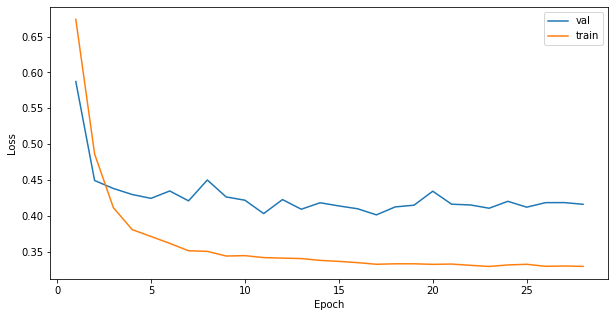

In [16]:
# Loss Graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Load a Trained Model (For Validation)

In [15]:
#helper to normilize our predictions
def normalize(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat == 1

In [14]:
#Reload the best weights
class_model.load_state_dict(torch.load('./model/best/model_KoELECTRA-base_17.pt'))

# Put the model in GPU
class_model.cuda(1)

WiC_Head(
  (embedder): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [16]:
validation_predictions_correctness = {}
# Validation

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Put model in evaluation mode
class_model.eval()

#Evaluation loop
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.cuda(1) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_token_ids, b_input_mask, b_labels, b_word1, b_word2, b_index = batch
    
    #Adapted gradient optimizer
    with torch.no_grad():
        loss, logits = class_model(b_input_ids, attention_mask=b_input_mask, 
                                    labels=b_labels, word1_locs = b_word1, word2_locs = b_word2)

    #Use CPU for accuracy calcs
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()
    b_accuracy, b_pred_correctness = flat_accuracy(logits, label_ids, return_predict_correctness = True)
    indexes = b_index.detach().cpu().numpy()

    for index, pred in zip(indexes, b_pred_correctness):
        validation_predictions_correctness[index] = pred

    eval_loss += loss.item()
    eval_accuracy += b_accuracy
    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

    if nb_eval_steps%10 == 0:
        print("\t\tValidation Batch {}: Loss: {}; Accuracy: {}".format(nb_eval_steps, loss.item(), b_accuracy))
        
print("Validation:\n\tLoss: {}; Accuracy: {}".format(eval_loss/nb_eval_steps, eval_accuracy/nb_eval_steps))
validation_predictions_correctness = collections.OrderedDict(sorted(validation_predictions_correctness.items()))
# print(validation_predictions_correctness)

/home/dmserver/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


		Validation Batch 10: Loss: 0.4491198658943176; Accuracy: 0.84375
		Validation Batch 20: Loss: 0.4143008291721344; Accuracy: 0.90625
		Validation Batch 30: Loss: 0.4347462058067322; Accuracy: 0.875
Validation:
	Loss: 0.4012271584691228; Accuracy: 0.9096283783783784


## Inference

- 여기서부터 순서대로 실행하면 inference를 할 수 있게 csv->jsonl 변환 코드를 다시 넣고 필요한 변수와 함수들을 다시 정의하였습니다.
- 이 ipynb 파일과 같은 디렉토리 안에 ./data/NIKL_SKT_WiC_Train.tsv, NIKL_SKT_WiC_Dev.tsv, NIKL_SKT_WiC_Test.tsv 파일이 있어야 inference를 할 수 있습니다.

In [11]:
# 이 경로에 데이터가 있어야 함!
df_train = pd.read_csv('./data/NIKL_SKT_WiC_Train.tsv', sep="\t")
df_val = pd.read_csv('./data/NIKL_SKT_WiC_Dev.tsv', sep="\t")
df_test = pd.read_csv('./data/NIKL_SKT_WiC_Test.tsv', sep="\t")

df_list = [df_train, df_val, df_test]
for df in df_list:
    df.rename(columns = {'Target':'word', 
                         'SENTENCE1':'sentence1',
                         'SENTENCE2':'sentence2',
                         'ANSWER':'label',
                         'start_s1':'start1',
                         'start_s2':'start2',
                         'end_s1':'end1',
                         'end_s2':'end2'}, inplace = True)
    
# jsonl 파일로 저장
df_train.to_json('./data/WiC_train.jsonl', orient='records', lines=True, force_ascii = False)
df_val.to_json('./data/WiC_val.jsonl', orient='records', lines=True, force_ascii = False)
df_test.to_json('./data/WiC_test.jsonl', orient='records', lines=True, force_ascii = False)

In [12]:
def normalize(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat == 1

#Testing the accuracy of our model
def flat_accuracy(preds, labels, return_predict_correctness = False):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    if return_predict_correctness:
        return np.sum(pred_flat == labels_flat) / len(labels_flat), pred_flat == labels_flat, pred_flat # 추가함
    else:
        return np.sum(pred_flat == labels_flat) / len(labels_flat)
        
class WiC_Head(torch.nn.Module):
    def __init__(self, specific_model, embedding_size = 768):
        """
        add a linear layer to take the distance between two 
        """
        super(WiC_Head, self).__init__()
        self.embedding_size = embedding_size
        self.embedder = specific_model
        self.linear_diff = torch.nn.Linear(embedding_size, 250, bias = True)
        self.linear_seperator = torch.nn.Linear(250, 2, bias = True)
        self.loss = torch.nn.CrossEntropyLoss()
        self.activation = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    def forward(self, input_ids=None, attention_mask=None, labels=None,
                word1_locs = None, word2_locs = None):
        """
        same parameters as RoBERTa forward adding two tensors for the location of the 2 words to compare them
        """
        batch_size = word1_locs.shape[0]
        # get the embeddings (numerical representation)
        embs = self.embedder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state # 수정함
        
        # The words from the sentences
        word1s = torch.matmul(word1_locs, embs).view(batch_size, self.embedding_size)
        word2s = torch.matmul(word2_locs, embs).view(batch_size, self.embedding_size)
        
        # seeing how different are the words by substracting the numbers that represent the words
        diff = word1s - word2s
        
        # Calculate outputs using activation
        layer1_results = self.activation(self.linear_diff(diff))
        logits = self.softmax(self.linear_seperator(layer1_results))
        outputs = logits
        
        # Calculate prediction label
        if labels is not None:
            loss = self.loss(logits.view(-1, 2), labels.view(-1))
            outputs = (loss, logits)
        return outputs

#Readfile function to take all the objects out of jsonl files
def parse_file_to_JSON(filename):
    serparated_json_objs = []
    
    #grab each line and add it as an element in json objs arr
    with open(filename, mode = "r") as jsonl_file:
        for i in jsonl_file:
            serparated_json_objs.append(json.loads(i))

    return serparated_json_objs

#Take a list of words (strings) and a sentence and returns a list
#of pairs indicating the tokens' start and end positions in the sentence for each word
#Create a function that matches word in tokenized sentence
def find_word_in_tokenized_sentence(word,token_ids):
    
    # decomposedWord = tokenizer.encode(word)
    decomposedWord = tokenizer.encode(word)[1:-1] # 수정함
    
    # print('decomposedWord:', decomposedWord) # 추가함
   #Iterate through to find a matching sublist of the token_ids
    for i in range(len(token_ids)):
        if token_ids[i] == decomposedWord[0] and token_ids[i:i+len(decomposedWord)] == decomposedWord:
            return (i,i+len(decomposedWord)-1)
    #finalize the output if there is no matching pattern found
    # print('returned -1 -1') # 추가함
    return (-1,-1)
  
def find_words_in_tokenized_sentences(wordList,token_ids):
    #Create a intList that marks the positions of words
    intList = []
    #if intList is empty, call the previous function as no matching pattern found
    for word in wordList:
        if len(intList) == 0:
            intList.append(find_word_in_tokenized_sentence(word,token_ids))
        else:
            afterLastInterval = intList[-1][1]+1
            interv = find_word_in_tokenized_sentence(word,token_ids[afterLastInterval:])
            actualPositions = (interv[0] + afterLastInterval,interv[1]+afterLastInterval)
            intList.append(actualPositions)
    return intList

def preprocessing(json_objects, training = True):
    
    wic_sentences, wic_encoded, wic_labels, wic_word_locs, wic_indexes = [], [], [] ,[] ,[]
    
    for index, example in enumerate(json_objects):
        
        wic_indexes.append(index)
        sentence = f"<s>{example['sentence1']}</s><s>{example['sentence2']}</s>"
        wic_sentences.append(sentence)

        wic_encoded.append(tokenizer.encode(sentence))
        
        # locate word in context
        word = example['word']
        location_of_word = (-1, -1)
        sent1_split = example['sentence1'].split(' ')
        sent2_split = example['sentence2'].split(' ')
        
        # wic indx
        sent1_word_char_loc = (example['start1'], example['end1'])
        sent2_word_char_loc = (example['start2'], example['end2'])
        
        num_characters = 0
        
        i, j = 0, 0
        word1_not_found, word2_not_found = True, True
        
        #locate word one
        while word1_not_found and i < len(sent1_split):
            word_len = len(sent1_split[i])
            if num_characters >= sent1_word_char_loc[0] or num_characters + word_len >= sent1_word_char_loc[1]:
                location_of_word = (i, -1) # Found the word in the sentence
                word1_not_found = False
            elif num_characters > sent1_word_char_loc[1]:
                location_of_word = (i - 1, -1)
                word1_not_found = False
            else:
                num_characters += word_len + 1 
                i += 1
                
        #locate word two
        num_characters = 0
        
        while word2_not_found and j < len(sent2_split):
            word_len = len(sent2_split[j])
            if num_characters >= sent2_word_char_loc[0] or num_characters + word_len >= sent2_word_char_loc[1]:
                location_of_word = (i, j)
                word2_not_found = False
            elif num_characters > sent2_word_char_loc[1]:
                location_of_word = (i, j - 1)
                word2_not_found = False
            else:
                num_characters += word_len + 1
                j += 1
                
        # Now to find the word in the tokenized sentences
        word1 = sent1_split[location_of_word[0]].translate(str.maketrans('', '', string.punctuation)) #Remove punctuation (See https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string)
        word2 = sent2_split[location_of_word[1]].translate(str.maketrans('', '', string.punctuation)) #Remove punctuation
        # print('word1:', word1) # 추가함
        # print('word2:', word2) # 추가함
        token_word_locs = find_words_in_tokenized_sentences([word1, word2], wic_encoded[-1])
        # print('wic_encoded[-1]:', wic_encoded[-1]) # 추가함
        # print('token_word_locs:', token_word_locs) # 추가함
        # print() # 추가함
        wic_word_locs.append(token_word_locs)
        
        # Get the label if we expect it to be there
        if training:
            if example['label']:
                wic_labels.append(1)
            else:
                wic_labels.append(0)
                
    # Pad the sequences and find the encoded word location in the combined input
    max_len = np.array([len(ex) for ex in wic_encoded]).max()
    wic_padded = {"input_ids" : [], "attention_mask" : [], "token_type_ids" : [], "word1_locs": [], "word2_locs" : [], "index" : wic_indexes}
    for i in range(0, len(wic_encoded)):
        enc_sentence = wic_encoded[i]
        location_of_word = wic_word_locs[i]
        # Pad the sequences
        ex_len = len(enc_sentence)
        padded_sentence = enc_sentence.copy()
        padded_sentence.extend([0]*(max_len - ex_len))
        wic_padded["input_ids"].append(padded_sentence)
        padded_mask = [1] * ex_len
        padded_mask.extend([0]*(max_len - ex_len))
        wic_padded["attention_mask"].append(padded_mask)
        # Create the vector to get back the words
        token_word_locs = wic_word_locs[i]
        first_word_loc = []
        second_word_loc = []
        len_first_word = token_word_locs[0][1] - token_word_locs[0][0] + 1
        len_second_word = token_word_locs[1][1] - token_word_locs[1][0] + 1
        for j in range(0, max_len):
            if j >= token_word_locs[0][0] and j <= token_word_locs[0][1]:
                #Part of the first word
                first_word_loc.append(1.0 / len_first_word)
            else:
                first_word_loc.append(0.0)
            if j >= token_word_locs[1][0] and j <= token_word_locs[1][1]:
                #Part of the second word
                second_word_loc.append(1.0 / len_second_word)
            else:
                second_word_loc.append(0.0)
        #We want to append a [1, max_len] vector instead of a [max_len] vector so wrap in an array
        wic_padded["word1_locs"].append([first_word_loc])
        wic_padded["word2_locs"].append([second_word_loc])
        #token_type_ids is a mask that tells where the first and second sentences are
        token_type_id = []
        first_sentence = True
        sentence_start = True
        for token in padded_sentence:
            if first_sentence and sentence_start and token == 0:
                #Allows 0 at the start of the first sentence
                token_type_id.append(0)
            elif first_sentence and token > 0:
                if sentence_start:
                    sentence_start = False
                token_type_id.append(0)
            elif first_sentence and not sentence_start and token == 0:
                first_sentence = False
                #Start of second sentence
                token_type_id.append(1)
            else:
                #Second sentence
                token_type_id.append(1)
        wic_padded["token_type_ids"].append(token_type_id)
        
    if training:
        for_tensor = {"input_ids": wic_padded["input_ids"], "token_type_ids": wic_padded["token_type_ids"],"attention_mask": wic_padded["attention_mask"], "labels": wic_labels, "index" : wic_padded["index"],"word1_locs": wic_padded["word1_locs"], "word2_locs" : wic_padded["word2_locs"]}
    else:
        for_tensor = {"input_ids": wic_padded["input_ids"], "token_type_ids": wic_padded["token_type_ids"], "attention_mask": wic_padded["attention_mask"], "index" : wic_padded["index"], "word1_locs": wic_padded["word1_locs"], "word2_locs" : wic_padded["word2_locs"]}

    return for_tensor

## 모델 1. monlogg/koelectra-base-v3-discriminator

In [13]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

BATCH_SIZE = 32

# 모델 - monlogg/koelectra-base-v3-discriminator
model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
model_name = 'KoELECTRA-base-v3-dis'
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
class_model = WiC_Head(model, embedding_size = 768)
class_model.load_state_dict(torch.load('./saved_model/동형이의어_KoELECTRA-base-v3-dis.pt'))

# Put the model in GPU
# class_model.cuda(1)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [14]:
#This loads the jsonl files and make json using the helper functions
test_json_objs = parse_file_to_JSON('./data/WiC_test.jsonl')
valid_json_objs = parse_file_to_JSON('./data/WiC_val.jsonl')

#This does the preprocessing step for our json objects
raw_test_set = preprocessing(test_json_objs, training = False)
raw_valid_set = preprocessing(valid_json_objs)

#These are out test and validation data sets to be used to get our final accuracy and our results
#for the test.jsonl file.
test_data = TensorDataset(
    torch.tensor(raw_test_set["input_ids"]).to(device),
    torch.tensor(raw_test_set["token_type_ids"]).to(device),
    torch.tensor(raw_test_set["attention_mask"]).to(device),
    torch.tensor(raw_test_set["word1_locs"]).to(device),
    torch.tensor(raw_test_set["word2_locs"]).to(device),
    torch.tensor(raw_test_set["index"]).to(device)
)
validation_data = TensorDataset(
    torch.tensor(raw_valid_set["input_ids"]).to(device),
    torch.tensor(raw_valid_set["token_type_ids"]).to(device),
    torch.tensor(raw_valid_set["attention_mask"]).to(device),
    torch.tensor(raw_valid_set["labels"]).to(device),
    torch.tensor(raw_valid_set["word1_locs"]).to(device),
    torch.tensor(raw_valid_set["word2_locs"]).to(device),
    torch.tensor(raw_valid_set["index"]).to(device)
)

#This makes the sampler and data loader for the end of our program
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [15]:
validation_predictions_correctness = {}
# Validation

pred_all = np.empty((0))
ans_all = np.empty((0))
logit_all = np.empty((0,2))

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Put model in evaluation mode
class_model.eval()

#Evaluation loop
for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.cuda(1) for t in batch) # GPU 사용할 때
    batch = tuple(t for t in batch) # CPU 사용할 때
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_token_ids, b_input_mask, b_labels, b_word1, b_word2, b_index = batch
    
    #Adapted gradient optimizer
    with torch.no_grad():
        loss, logits = class_model(b_input_ids, attention_mask=b_input_mask, 
                                    labels=b_labels, word1_locs = b_word1, word2_locs = b_word2)

    #Use CPU for accuracy calcs
    logits = logits.detach().cpu().numpy()
    logit_all = np.append(logit_all, logits, axis=0)
    label_ids = b_labels.cpu().numpy()
    b_accuracy, b_pred_correctness, b_pred = flat_accuracy(logits, label_ids, return_predict_correctness = True)

    # pred_all.extend(b_pred.tolist())
    # ans_all.extend(label_ids.tolist())
    
    pred_all = np.append(pred_all, b_pred, axis=0)
    ans_all = np.append(ans_all, label_ids, axis=0)
    
    indexes = b_index.detach().cpu().numpy()

    for index, pred in zip(indexes, b_pred_correctness):
        validation_predictions_correctness[index] = pred

    eval_loss += loss.item()
    eval_accuracy += b_accuracy
    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

    if nb_eval_steps%10 == 0:
        print("\t\tValidation Batch {}: Loss: {}; Accuracy: {}".format(nb_eval_steps, loss.item(), b_accuracy))
        
print("Validation:\n\tLoss: {}; Accuracy: {}".format(eval_loss/nb_eval_steps, eval_accuracy/nb_eval_steps))
validation_predictions_correctness = collections.OrderedDict(sorted(validation_predictions_correctness.items()))
# print(validation_predictions_correctness)

/home/dmserver/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


		Validation Batch 10: Loss: 0.4646112322807312; Accuracy: 0.84375
		Validation Batch 20: Loss: 0.3987000584602356; Accuracy: 0.90625
		Validation Batch 30: Loss: 0.4068596363067627; Accuracy: 0.90625
Validation:
	Loss: 0.40866498528300105; Accuracy: 0.9045608108108109


monlogg/koelectra-base-v3-discriminator 단일 모델 Accuracy: 90.46%

In [16]:
result = np.concatenate((logit_all, np.reshape(pred_all,(pred_all.shape[0],-1)), np.reshape(ans_all,(ans_all.shape[0],-1))), axis=1)
df_result1 = pd.DataFrame(result, columns = ['prob_F', 'prob_T', 'prediction', 'answer'])
df_result1

,prob_F,prob_T,prediction,answer
0,0.999983,0.000017,0.0,0.0
1,0.999988,0.000012,0.0,0.0
2,0.999988,0.000012,0.0,0.0
3,0.000025,0.999975,1.0,1.0
4,0.000017,0.999983,1.0,1.0
...,...,...,...,...
1161,0.999993,0.000007,0.0,0.0
1162,0.421832,0.578168,1.0,1.0
1163,0.000008,0.999992,1.0,1.0
1164,0.999926,0.000074,0.0,0.0


## 모델 2. tunib/electra-ko-base

In [17]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 모델 - tunib/electra-ko-base
model = AutoModel.from_pretrained('tunib/electra-ko-base')
model_name = 'KoELECTRA-base'
tokenizer = AutoTokenizer.from_pretrained('tunib/electra-ko-base')
class_model = WiC_Head(model, embedding_size = 768)
class_model.load_state_dict(torch.load('./saved_model/동형이의어_KoELECTRA-base.pt'))

# Put the model in GPU
# class_model.cuda(1)

Some weights of the model checkpoint at tunib/electra-ko-base were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [18]:
#This loads the jsonl files and make json using the helper functions
test_json_objs = parse_file_to_JSON('./data/WiC_test.jsonl')
valid_json_objs = parse_file_to_JSON('./data/WiC_val.jsonl')

#This does the preprocessing step for our json objects
raw_test_set = preprocessing(test_json_objs, training = False)
raw_valid_set = preprocessing(valid_json_objs)

#These are out test and validation data sets to be used to get our final accuracy and our results
#for the test.jsonl file.
test_data = TensorDataset(
    torch.tensor(raw_test_set["input_ids"]).to(device),
    torch.tensor(raw_test_set["token_type_ids"]).to(device),
    torch.tensor(raw_test_set["attention_mask"]).to(device),
    torch.tensor(raw_test_set["word1_locs"]).to(device),
    torch.tensor(raw_test_set["word2_locs"]).to(device),
    torch.tensor(raw_test_set["index"]).to(device)
)
validation_data = TensorDataset(
    torch.tensor(raw_valid_set["input_ids"]).to(device),
    torch.tensor(raw_valid_set["token_type_ids"]).to(device),
    torch.tensor(raw_valid_set["attention_mask"]).to(device),
    torch.tensor(raw_valid_set["labels"]).to(device),
    torch.tensor(raw_valid_set["word1_locs"]).to(device),
    torch.tensor(raw_valid_set["word2_locs"]).to(device),
    torch.tensor(raw_valid_set["index"]).to(device)
)

#This makes the sampler and data loader for the end of our program
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [19]:
validation_predictions_correctness = {}
# Validation

pred_all = np.empty((0))
ans_all = np.empty((0))
logit_all = np.empty((0,2))

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Put model in evaluation mode
class_model.eval()

#Evaluation loop
for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.cuda(1) for t in batch) # GPU 사용할 때
    batch = tuple(t for t in batch) # CPU 사용할 때
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_token_ids, b_input_mask, b_labels, b_word1, b_word2, b_index = batch
    
    #Adapted gradient optimizer
    with torch.no_grad():
        loss, logits = class_model(b_input_ids, attention_mask=b_input_mask, 
                                    labels=b_labels, word1_locs = b_word1, word2_locs = b_word2)

    #Use CPU for accuracy calcs
    logits = logits.detach().cpu().numpy()
    logit_all = np.append(logit_all, logits, axis=0)
    label_ids = b_labels.cpu().numpy()
    b_accuracy, b_pred_correctness, b_pred = flat_accuracy(logits, label_ids, return_predict_correctness = True)

    # pred_all.extend(b_pred.tolist())
    # ans_all.extend(label_ids.tolist())
    
    pred_all = np.append(pred_all, b_pred, axis=0)
    ans_all = np.append(ans_all, label_ids, axis=0)
    
    indexes = b_index.detach().cpu().numpy()

    for index, pred in zip(indexes, b_pred_correctness):
        validation_predictions_correctness[index] = pred

    eval_loss += loss.item()
    eval_accuracy += b_accuracy
    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

    if nb_eval_steps%10 == 0:
        print("\t\tValidation Batch {}: Loss: {}; Accuracy: {}".format(nb_eval_steps, loss.item(), b_accuracy))
        
print("Validation:\n\tLoss: {}; Accuracy: {}".format(eval_loss/nb_eval_steps, eval_accuracy/nb_eval_steps))
validation_predictions_correctness = collections.OrderedDict(sorted(validation_predictions_correctness.items()))
# print(validation_predictions_correctness)

/home/dmserver/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


		Validation Batch 10: Loss: 0.44911959767341614; Accuracy: 0.84375
		Validation Batch 20: Loss: 0.4143008291721344; Accuracy: 0.90625
		Validation Batch 30: Loss: 0.4347462058067322; Accuracy: 0.875
Validation:
	Loss: 0.4012270916152645; Accuracy: 0.9096283783783784


tunib/electra-ko-base 단일 모델 Accuracy: 90.96%

In [20]:
result = np.concatenate((logit_all, np.reshape(pred_all,(pred_all.shape[0],-1)), np.reshape(ans_all,(ans_all.shape[0],-1))), axis=1)
df_result2 = pd.DataFrame(result, columns = ['prob_F', 'prob_T', 'prediction', 'answer'])
df_result2

,prob_F,prob_T,prediction,answer
0,0.999890,0.000110,0.0,0.0
1,0.999967,0.000033,0.0,0.0
2,0.999885,0.000115,0.0,0.0
3,0.000002,0.999997,1.0,1.0
4,0.000015,0.999985,1.0,1.0
...,...,...,...,...
1161,0.999991,0.000009,0.0,0.0
1162,0.205595,0.794405,1.0,1.0
1163,0.000002,0.999998,1.0,1.0
1164,0.999980,0.000020,0.0,0.0


## Ensemble (Soft Voting)

In [21]:
# 정답 label
answer = df_result1['answer'].tolist()

In [22]:
prob1 = df_result1['prob_F']
prob2 = df_result2['prob_F']

prob = (prob1+prob2)/2
prob = prob.tolist()

In [23]:
final_pred = []
for i in prob:
    if i >= 0.5: 
        final_pred.append(0)
    else: 
        final_pred.append(1)

print(accuracy_score(answer, final_pred))

0.9228130360205832


최종 Accuracy: 92.28%

# 3. 인과관계추론

## Functions

In [51]:
import os
import random
import argparse
import pandas as pd
from importlib import import_module
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import transformers
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

class CrossEntropy(nn.Module):
    def __init__(self):
        super(CrossEntropy, self).__init__()
        self.CE = nn.CrossEntropyLoss()
        return

    def forward(self, inputs, target):
        """
        :param inputs: predictions
        :param target: target labels
        :return: loss
        """
        # target = torch.argmax(target, dim=-1)
        loss = self.CE(inputs, target)
        return loss


_criterion_entrypoints = {
    'cross_entropy': CrossEntropy,
}

def criterion_entrypoint(criterion_name):
    return _criterion_entrypoints[criterion_name]

def is_criterion(criterion_name):
    return criterion_name in _criterion_entrypoints

def create_criterion(criterion_name, **kwargs):
    if is_criterion(criterion_name):
        create_fn = criterion_entrypoint(criterion_name)
        criterion = create_fn(**kwargs)
    else:
        raise RuntimeError('Unknown loss (%s)' % criterion_name)
    return criterion



# Dataset 구성.
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def load_data(dataset_dir):
    dataset = pd.read_csv(dataset_dir, delimiter='\t', names=['ID', 'sentence', 'question', '1', '2','answer'], header=0)
    dataset["label"] = dataset["answer"].astype(int) - 1

    new_sentence1_1 = []
    new_sentence1_2 = []
    new_sentence2_1 = []
    new_sentence2_2 = []
    for i in range(len(dataset)):
        s = dataset.iloc[i]['sentence']
        q = dataset.iloc[i]['question']
        s1 = dataset.iloc[i]['1']
        s2 = dataset.iloc[i]['2']
        lb = dataset.iloc[i]['label']
        if q == "결과":
            new_sentence1_1.append("[결과]" + s)
            # new_sentence1_1.append(s)
            new_sentence1_2.append(s1)
            new_sentence2_1.append("[결과]" + s)
              # new_sentence2_1.append(s)
            new_sentence2_2.append(s2)

        else:
            new_sentence1_1.append("[원인]" + s1)
            # new_sentence1_1.append(s1)
            new_sentence1_2.append(s)
            new_sentence2_1.append("[원인]" + s2)
            # new_sentence2_1.append(s2)
            new_sentence2_2.append(s)

    dataset["new_sentence1_1"] = new_sentence1_1
    dataset["new_sentence1_2"] = new_sentence1_2
    dataset["new_sentence2_1"] = new_sentence2_1
    dataset["new_sentence2_2"] = new_sentence2_2

    return dataset


def tokenized_dataset(dataset, tokenizer, arch="encoder"):
    sentence1_1 = dataset['new_sentence1_1'].tolist()
    sentence1_2 = dataset['new_sentence1_2'].tolist()
    sentence2_1 = dataset["new_sentence2_1"].tolist()
    sentence2_2 = dataset["new_sentence2_2"].tolist()

    tokenized_sentences = tokenizer(
          sentence1_1,
          sentence1_2,
          return_tensors="pt",
          padding=True,
          truncation=True,
          max_length=150,
          add_special_tokens=True,
          return_token_type_ids = True
          )
    tokenized_sentences2 = tokenizer(
          sentence2_1,
          sentence2_2,
          return_tensors="pt",
          padding=True,
          truncation=True,
          max_length=150,
          add_special_tokens=True,
          return_token_type_ids = True
          )
    for key, value in tokenized_sentences2.items():
        tokenized_sentences[key+"2"] = value
    
    return tokenized_sentences


# seed 고정 
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Model

In [38]:
import torch
import torch.nn as nn
from transformers import BertModel, BertPreTrainedModel, ElectraModel, ElectraPreTrainedModel, XLMRobertaModel, BartModel, BartPretrainedModel, T5Model, RobertaModel 
from transformers import MBartModel, MBartConfig
from transformers import BertTokenizer, BertModel


class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.0, use_activation=True):
        super(FCLayer, self).__init__()
        self.use_activation = use_activation
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.dropout(x)
        if self.use_activation:
            x = self.tanh(x)
        return self.linear(x)


class PoolingHead(nn.Module):

    def __init__(
        self,
        input_dim: int,
        inner_dim: int,
        pooler_dropout: float,
    ):
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=pooler_dropout)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        return hidden_states




class Electra_BoolQ(ElectraPreTrainedModel):
    def __init__(self, config, args):
        super(Electra_BoolQ, self).__init__(config)

        #self.num_labels = config.num_labels
        self.num_labels = config.num_labels
        self.model = ElectraModel.from_pretrained('monologg/koelectra-base-v3-discriminator', config=config)
        self.pooling = PoolingHead(input_dim=config.hidden_size,
            inner_dim=config.hidden_size,
            pooler_dropout=0.1)
        self.qa_classifier = nn.Linear(config.hidden_size, self.num_labels -1)
        #self.sparse = Sparsemax()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, input_ids2=None, attention_mask2=None, token_type_ids2=None, labels=None):
        outputs = self.model(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )  # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs2 = self.model(
            input_ids2, attention_mask=attention_mask2, token_type_ids=token_type_ids2
        )
        sequence_output = outputs[0]
        sequence_output2 = outputs2[0]
        pooled_output = outputs[0][:, 0, :]  # [CLS]
        pooled_output2 = outputs2[0][:, 0, :]

        sentence_representation = torch.cat([pooled_output, pooled_output2], dim=1)

        pooled_output = self.pooling(pooled_output)
        pooled_output2 = self.pooling(pooled_output2)
        
        logits1 = self.qa_classifier(pooled_output)
        logits2 = self.qa_classifier(pooled_output2)

        logits = torch.cat([logits1, logits2], dim=1)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        return outputs  # logits, (hidden_states), (attentions)


class CustomPreTrainModel(RobertaModel):
    def __init__(self, config, model):
        super(CustomPreTrainModel, self).__init__(config)
        self.model = model
        self.num_labels = 2
        self.qa_classifier_final = nn.Linear(self.num_labels*2, self.num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, input_ids2=None, attention_mask2=None, token_type_ids2=None, labels=None):
        out1 = self.model(input_ids, attention_mask=attention_mask)[0]   # B, C   (여기서 C는 2라서 concat후 다시 2차원 변환 필요)
        out2 = self.model(input_ids2, attention_mask=attention_mask2)[0]

        out_cat = torch.cat([out1, out2], dim=1)   # B, C*2
        logits = self.qa_classifier_final(out_cat)

        outputs = (logits,) + (0,)

        return outputs


## Data Load, Parameter Setting

In [30]:
# Dataset 구성.
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def load_data(dataset_dir):
    dataset = pd.read_csv(dataset_dir, delimiter='\t', names=['ID', 'sentence', 'question', '1', '2','answer'], header=0)
    dataset["label"] = dataset["answer"].astype(int) - 1

    new_sentence1_1 = []
    new_sentence1_2 = []
    new_sentence2_1 = []
    new_sentence2_2 = []
    for i in range(len(dataset)):
        s = dataset.iloc[i]['sentence']
        q = dataset.iloc[i]['question']
        s1 = dataset.iloc[i]['1']
        s2 = dataset.iloc[i]['2']
        lb = dataset.iloc[i]['label']
        if q == "결과":
            new_sentence1_1.append("[결과]" + s)
            # new_sentence1_1.append(s)
            new_sentence1_2.append(s1)
            new_sentence2_1.append("[결과]" + s)
              # new_sentence2_1.append(s)
            new_sentence2_2.append(s2)

        else:
            new_sentence1_1.append("[원인]" + s1)
            # new_sentence1_1.append(s1)
            new_sentence1_2.append(s)
            new_sentence2_1.append("[원인]" + s2)
            # new_sentence2_1.append(s2)
            new_sentence2_2.append(s)

    dataset["new_sentence1_1"] = new_sentence1_1
    dataset["new_sentence1_2"] = new_sentence1_2
    dataset["new_sentence2_1"] = new_sentence2_1
    dataset["new_sentence2_2"] = new_sentence2_2

    return dataset


def tokenized_dataset(dataset, tokenizer, arch="encoder"):
    sentence1_1 = dataset['new_sentence1_1'].tolist()
    sentence1_2 = dataset['new_sentence1_2'].tolist()
    sentence2_1 = dataset["new_sentence2_1"].tolist()
    sentence2_2 = dataset["new_sentence2_2"].tolist()

    tokenized_sentences = tokenizer(
          sentence1_1,
          sentence1_2,
          return_tensors="pt",
          padding=True,
          truncation=True,
          max_length=150,
          add_special_tokens=True,
          return_token_type_ids = True
          )
    tokenized_sentences2 = tokenizer(
          sentence2_1,
          sentence2_2,
          return_tensors="pt",
          padding=True,
          truncation=True,
          max_length=150,
          add_special_tokens=True,
          return_token_type_ids = True
          )
    for key, value in tokenized_sentences2.items():
        tokenized_sentences[key+"2"] = value
    
    return tokenized_sentences

## Load parameter

In [31]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
parser = argparse.ArgumentParser()
parser.add_argument('--model_type', type=str, default='BertBase')
parser.add_argument('--pretrained_model', type=str, default='bert-base-uncased')

parser.add_argument('--epochs', type=int, default=10)
parser.add_argument('--freeze_epoch', type=int, default=0)
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--valid_batch_size', type=int, default=128)
parser.add_argument('--val_ratio', type=float, default=0.2, help='ratio for validaton (default: 0.2)')
parser.add_argument('--dropout_rate', type=float, default=0.1, help="Dropout for fully-connected layers")

parser.add_argument('--criterion', type=str, default='cross_entropy', help='criterion type (default: cross_entropy)')
parser.add_argument('--optimizer', type=str, default='AdamW', help='optimizer type (default: AdamW)')

parser.add_argument('--lr', type=float, default=1e-6)
parser.add_argument('--weight_decay', type=float, default=0.01)
parser.add_argument('--warmup_steps', type=int, default=500)               # number of warmup steps for learning rate scheduler
parser.add_argument('--seed' , type=int , default = 42, help='random seed (default: 42)')
parser.add_argument('--log_interval', type=int, default=20, help='how many batches to wait before logging training status')
parser.add_argument('--kfold', type=int, default=1, help='k-fold currunt step number')

parser.add_argument('--name', default='exp', help='model save at {SM_MODEL_DIR}/{name}')
parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR', './results'))
parser.add_argument('--custompretrain', type=str, default="", help='Use custom pretrain : model dir')

args = parser.parse_args("")


In [32]:
args.epochs = 15
args.pretrained_model = 'monologg/koelectra-base-v3-discriminator'
args.lr = 8e-6
args.batch_size = 16

args.kfold = 1
args.batch_size=4
args.valid_batch_size=16
args.model_type = "koelectra-base-v3-discriminator"

args.name = f'Train_{args.model_type}_{args.lr}'

MODEL_NAME = args.pretrained_model

In [33]:
seed_everything(args.seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device(GPU) : {torch.cuda.is_available()}")
num_classes = 2

device(GPU) : True


### Load Data, Pre-trained Model

In [40]:
# load model and tokenizerƒ

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# load dataset
train_dataset = load_data("./data/SKT_COPA_Train.tsv")
val_dataset = load_data("./data/SKT_COPA_Dev.tsv")

In [41]:
train_label = train_dataset['label'].values
val_label = val_dataset['label'].values

# tokenizing dataset
tokenized_train = tokenized_dataset(train_dataset, tokenizer)
tokenized_val = tokenized_dataset(val_dataset, tokenizer)

# make dataset for pytorch.
train_dataset = CustomDataset(tokenized_train, train_label)
val_dataset = CustomDataset(tokenized_val, val_label)

config_module = getattr(import_module("transformers"), "ElectraConfig")
model_config = config_module.from_pretrained(MODEL_NAME)
model_config.num_labels = 2
model_module = eval('Electra_BoolQ')

save_dir = args.model_dir+"3"
model = model_module(config=model_config, args=args)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
# -- data_loader
train_loader = DataLoader(
      train_dataset,
      batch_size=args.batch_size,
      shuffle=True,
      drop_last=True,
  )

val_loader = DataLoader(
      val_dataset,
      batch_size=args.valid_batch_size,
      shuffle=False,
      drop_last=False,
  )

In [47]:
for name, param in model.named_parameters():
    if ('cls_fc_layer' not in name) and ('label_classifier' not in name): # classifier layer
        param.requires_grad = False

  # -- loss & metric
criterion = create_criterion(args.criterion)  # default: cross_entropy
opt_module = getattr(import_module("transformers"), args.optimizer)
optimizer = opt_module(
        model.parameters(),
        lr=args.lr,
        weight_decay=args.weight_decay,
        eps = 1e-8
    )

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=args.warmup_steps, 
    num_training_steps=len(train_loader) * args.epochs, 
    last_epoch=- 1
    )


### Train 코드

In [48]:
def train(model_dir, args):

    bs_list = [32,16,8,4,2]

    for bs in bs_list:
        print("batch_size : "+ str(bs))

        start_time = time.time()

        with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
            json.dump(vars(args), f, ensure_ascii=False, indent=4)


        best_val_acc = 0
        best_val_loss = np.inf
        for epoch in range(args.epochs):
            # train loop
            # unFreeze parameters
            if epoch == args.freeze_epoch:
                for name, param in model.named_parameters():
                    param.requires_grad = True
            model.train()
            loss_value = 0
            matches = 0
            for idx, items in enumerate(train_loader):
                item = {key: val for key, val in items.items()}

                optimizer.zero_grad()
                outs = model(**item)
                loss = criterion(outs[0], item['labels'])

                preds = torch.argmax(outs[0], dim=-1)

                loss.backward()
                optimizer.step()
                scheduler.step()

                loss_value += loss.item()
                matches += (preds == item['labels']).sum().item()
                if (idx + 1) % args.log_interval == 0:
                    train_loss = loss_value / args.log_interval
                    train_acc = matches / args.batch_size / args.log_interval
                    current_lr = get_lr(optimizer)
                    print(
                        f"Epoch[{epoch}/{args.epochs}]({idx + 1}/{len(train_loader)}) || "
                        f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
                    )



                    loss_value = 0
                    matches = 0

            # val loop
            with torch.no_grad():
                print("Calculating validation results...")
                model.eval()
                val_loss_items = []
                val_acc_items = []
                acc_okay = 0
                count_all = 0
                for idx, items in enumerate(tqdm(val_loader)):
                    sleep(0.01)
                    item = {key: val for key, val in items.items()}

                    outs = model(**item)

                    preds = torch.argmax(outs[0], dim=-1)
                    loss = criterion(outs[0], item['labels']).item()

                    acc_item = (item['labels'] == preds).sum().item()

                    val_loss_items.append(loss)
                    val_acc_items.append(acc_item)
                    acc_okay += acc_item
                    count_all += len(preds)

                val_loss = np.sum(val_loss_items) / len(val_loss_items)
                val_acc = acc_okay / count_all

                if val_acc > best_val_acc:
                    print(f"New best model for val acc : {val_acc:4.2%}! saving the best model..")
                    model_to_save = model.module if hasattr(model, "module") else model
                    model_to_save.save_pretrained(f"{save_dir}/best")
                    torch.save(args, os.path.join(f"{save_dir}/best", "training_args.bin"))
                    best_val_acc = val_acc
                    bs_best_dict2[bs][0] = best_val_acc
                    bs_best_dict2[bs][1] = val_loss

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                print(f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.4}|| "
                f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.4}")


                s = f'Time elapsed: {(time.time() - start_time)/60: .2f} min'
                print(s)
                print()


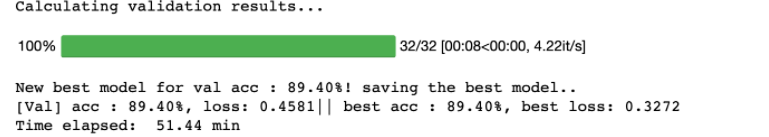

# Inference

In [52]:
def inference(model, tokenized_sent):
    dataloader = DataLoader(tokenized_sent, batch_size=8, shuffle=False)
    model.eval()
    results = []
    preds = []
  
    for i, items in enumerate(dataloader):
        item = {key: val for key, val in items.items()}
        with torch.no_grad():
            outputs = model(**item)
        logits = outputs[0]
        m = nn.Softmax(dim=1)
        logits = m(logits)
        logits = logits.detach().cpu().numpy()   # (Batch_size, 5)  5개의 클래스 확률형태
        pred = logits[:,1]
        result = np.argmax(logits, axis=-1)
        results += result.tolist()
        preds += pred.tolist()

    return np.array(results).flatten(), np.array(preds).flatten()

In [53]:
TOK_NAME = args.pretrained_model
tokenizer = AutoTokenizer.from_pretrained(TOK_NAME)

# load my model 
model_module = eval("Electra_BoolQ")

dataset = load_data("./data/SKT_COPA_Dev.tsv")
test_label = [0] * len(dataset)
tokenized_test = tokenized_dataset(dataset, tokenizer)
test_dataset = CustomDataset(tokenized_test, test_label)

model = model_module.from_pretrained("./saved_model/Task_3_Model", args=args)  
model.parameters
model.eval()
pred_answer, preds = inference(model, test_dataset)

print("Validation Accuracy : " + str(accuracy_score(dataset["label"],pred_answer)))

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Validation Accuracy : 0.894


# 4. 판정의문문

In [1]:
#GPU
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#Import modules
import pickle as pickle
import os
import pandas as pd
import torch
import re


#Custom dataset for the experiment
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#Preprocessing the data for QA experiment
#Translate special symbols and punctuation marks into Korean.
#using lower function for effective experiment

def pre_process(st):
    st = re.sub('\(.*\)|\s-\s.*', '', st)
    st = re.sub('\[.*\]|\s-\s.*', '', st)
    st = st.lower()

    st = re.sub('[”“]', '\"', st)
    st = re.sub('[’‘]', '\'', st)
    st = re.sub('[≫〉》＞』」]', '>', st)
    st = re.sub('[《「『〈≪＜]','<',st)
    st = re.sub('[−–—]', '−', st)
    st = re.sub('[･•・‧]','·', st)
    
    st = st.replace('／', '/')
    st = st.replace('℃', '도')
    st = st.replace('→', '에서')
    st = st.replace('!', '')
    st = st.replace('，', ',')
    st = st.replace('㎢', 'km')
    st = st.replace('∼', '~')
    st = st.replace('㎜', 'mm')
    st = st.replace('×', '곱하기')
    st = st.replace('=', '는')
    st = st.replace('®', '')
    st = st.replace('㎖', 'ml')
    st = st.replace('ℓ', 'l')
    st = st.replace('˚C', '도')
    st = st.replace('˚', '도')
    st = st.replace('°C', '도')
    st = st.replace('°', '도')
    st = st.replace('＋', '+')
    st = st.replace('*', '')
    st = st.replace(';', '.')
    return st


#Load data function to bring in data

def load_data(dataset_dir):
    dataset = pd.read_csv(dataset_dir, delimiter='\t', names=['ID', 'text', 'question', 'answer'], header=0)
    dataset["label"] = dataset["answer"].astype(int)
    return dataset


#Use encoder and decoder to tokenize the dataset
def tokenized_dataset(dataset, tokenizer, arch="encoder"):
    sentence = dataset['text'].tolist()
    sentence_d = dataset['question'].tolist()

    if arch=="encoder":        
        tokenized_sentences = tokenizer(
            sentence,
            sentence_d,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=350,
            add_special_tokens=True,
            return_token_type_ids = True
            )
        
        
    elif arch == "encoder-decoder":
        tokenized_sentences = tokenizer(
            sentence,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=350,
            add_special_tokens=True,
            return_token_type_ids = False
            )
        tokenized_sentences_d = tokenizer(
            sentence_d,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=350,
            add_special_tokens=True,
            return_token_type_ids = False
            )
        
        for key, value in tokenized_sentences_d.items():
            tokenized_sentences[key+"_d"] = value

    return tokenized_sentences


In [3]:
import torch
import torch.nn as nn
from transformers import XLMRobertaModel
import numpy as np


#We have to use this function when we use XLMRobertaModel
class get_similarity(XLMRobertaModel):
    def __init__(self, config, args):
        super(get_similarity, self).__init__(config)
        self.xlmroberta = XLMRobertaModel.from_pretrained("xlm-roberta-large")
        self.num_labels = config.num_labels
  
    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        outputs = self.xlmroberta(
          input_ids, attention_mask=attention_mask
        )
        print("forward outputs: ", outputs)


#This function is ued to check the architecture
def check_arch(model_type):
    archs = {
      "encoder" : ["Bert", "Electra", "XLMRoberta", "Electra_BoolQ", "Roberta"],
      "encoder-decoder" : ["T5", "Bart", "Bart_BoolQ"]
    }
    for arch in archs:
        if model_type in archs[arch]:
            return arch
    raise ValueError(f"Model [{model_type}] didn't defined archtecture")

In [4]:
#Importing modules
import torch.nn.functional as F


#Compute the cross entropy loss between input and target
class CrossEntropy(nn.Module):
    def __init__(self):
        super(CrossEntropy, self).__init__()
        self.CE = nn.CrossEntropyLoss()
        return

    def forward(self, inputs, target):
        loss = self.CE(inputs, target)
        return loss


_criterion_entrypoints = {
    'cross_entropy': CrossEntropy,
}

#?
def criterion_entrypoint(criterion_name):
    return _criterion_entrypoints[criterion_name]

def is_criterion(criterion_name):
    return criterion_name in _criterion_entrypoints

def create_criterion(criterion_name, **kwargs):
    if is_criterion(criterion_name):
        create_fn = criterion_entrypoint(criterion_name)
        criterion = create_fn(**kwargs)
    else:
        raise RuntimeError('Unknown loss (%s)' % criterion_name)
    return criterion

In [5]:
#import modules
import torch
import torch.nn as nn
from transformers import BertModel, BertPreTrainedModel, ElectraModel, ElectraPreTrainedModel, XLMRobertaModel, BartModel, BartPretrainedModel, T5Model, RobertaModel 
from transformers import MBartModel, MBartConfig
from transformers import BertTokenizer, BertModel

class PoolingHead(nn.Module):

    def __init__(
        self,
        input_dim: int,
        inner_dim: int,
        pooler_dropout: float,
    ):
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=pooler_dropout)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        return hidden_states
        
#RoBERTa: A Robustly Optimized BERT Pretraining Approach
#Carefully measure the impact of many key hyperparameters and training data size
#Achieve state-of-the-art results on GLUE, RACE and SQuAD
class Roberta(RobertaModel):
    def __init__(self, config, args):
        super(Roberta, self).__init__(config)
        self.roberta = RobertaModel.from_pretrained("klue/roberta-large", config=config)  # Load pretrained Electra

        self.num_labels = config.num_labels

        self.pooling = PoolingHead(input_dim=config.hidden_size,
            inner_dim=config.hidden_size,
            pooler_dropout=0.1)
        self.qa_classifier = nn.Linear(config.hidden_size, self.num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.roberta(
            input_ids, attention_mask=attention_mask
        )  
        pooled_output = outputs[0][:, 0, :]  # [CLS]

        pooled_output = self.pooling(pooled_output)
        
        
        logits = self.qa_classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  

        return outputs 

In [7]:
#Import modeuls
import pickle as pickle
import json
import os
import pandas as pd
import numpy as np
import random
import torch
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer
from transformers import MBartModel, MBartConfig
import transformers
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import argparse
from importlib import import_module
from pathlib import Path
import glob
import re
from collections import defaultdict
from sklearn.metrics import classification_report
from tqdm import tqdm
import time
from time import sleep
from transformers import PreTrainedTokenizerFast



#Fix seed 
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


#Metric computing function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
      'accuracy': acc,
    }


def increment_output_dir(output_path, exist_ok=False):
    path = Path(output_path)
    if (path.exists() and exist_ok) or (not path.exists()):
        return str(path)
    else:
        dirs = glob.glob(f"{path}*")
        matches = [re.search(rf"%s(\d+)" %path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]
        n = max(i) + 1 if i else 2
        return f"{path}{n}"


#Training model
def train(model_dir, args):
    seed_everything(args.seed)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"device(GPU) : {torch.cuda.is_available()}")
    num_classes = 2
  
    # Load model and use AutoTokenizer 
    #AutoTokenizer :A generic tokenizer class that will be instantiated as one of the tokenizer classes of the library
    MODEL_NAME = args.pretrained_model
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # Load Train dataset and validation dataset
    train_dataset = load_data("./data/SKT_BoolQ_Train.tsv")
    val_dataset = load_data("./data/SKT_BoolQ_Dev.tsv")

    #Fix target(label) of train and validation dataset
    train_label = train_dataset['label'].values
    val_label = val_dataset['label'].values

    #Tokenizing train and validation dataset
    tokenized_train = tokenized_dataset(train_dataset, tokenizer, check_arch(args.model_type))
    tokenized_val = tokenized_dataset(val_dataset, tokenizer, check_arch(args.model_type))

    #Custon the dataset for experiment using pytorch
    train_dataset = CustomDataset(tokenized_train, train_label)
    val_dataset = CustomDataset(tokenized_val, val_label)
    
    #This is data loader to load the data 
    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=args.valid_batch_size,
        shuffle=False,
        drop_last=False,
    )

  #Model hyperparameter setting 
    if args.model_type == 'Electra_BoolQ':
        config_module = getattr(import_module("transformers"), "ElectraConfig")
    else:
        config_module = getattr(import_module("transformers"), args.model_type + "Config")
  
    model_config = config_module.from_pretrained(MODEL_NAME)
    model_config.num_labels = 2

    model_module = eval(args.model_type)
    
    if args.custompretrain:
        model = model_module.from_pretrained(args.custompretrain, args=args)
        model = CustomPreTrainModel(config=model_config, model=model)
    else:
        if args.model_type in ["BERT", "Electra"]:
            model = model_module.from_pretrained(MODEL_NAME, config=model_config, args=args)
        else:
            model = model_module(config=model_config, args=args)
    model.parameters
    model.to(device)
    save_dir = increment_output_dir(os.path.join(model_dir, args.name, str(args.kfold)))

  # Freeze Parameter
    for name, param in model.named_parameters():
        if ('cls_fc_layer' not in name) and ('label_classifier' not in name): # classifier layer
            param.requires_grad = False

  #Computing loss and useing optimizer module
    criterion = create_criterion(args.criterion) 
    opt_module = getattr(import_module("transformers"), args.optimizer)
    optimizer = opt_module(
          model.parameters(),
          lr=args.lr,
          weight_decay=args.weight_decay,
          eps = 1e-8
      )
    scheduler = transformers.get_linear_schedule_with_warmup(
      optimizer, 
      num_warmup_steps=args.warmup_steps, 
      num_training_steps=len(train_loader) * args.epochs, 
      last_epoch=- 1
      )
    start_time = time.time()
    best_val_acc = -1
    best_val_loss = np.inf
    for epoch in range(args.epochs):
        pbar = tqdm(train_loader, dynamic_ncols=True)
    # This is train loop 
    # We have to unfreeze the parameters
        if epoch == args.freeze_epoch:
            for name, param in model.named_parameters():
                param.requires_grad = True
        model.train()
        loss_value = 0
        matches = 0
        for idx, items in enumerate(pbar):
            item = {key: val.to(device) for key, val in items.items()}
            optimizer.zero_grad()
            outs = model(**item)
            loss = criterion(outs[0], item['labels'])
            preds = torch.argmax(outs[0], dim=-1)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_value += loss.item()
            matches += (preds == item['labels']).sum().item()
            if (idx + 1) % args.log_interval == 0:
                train_loss = loss_value / args.log_interval
                train_acc = matches / args.batch_size / args.log_interval
                current_lr = get_lr(optimizer)
                pbar.set_description(f"Epoch: [{epoch}/{args.epochs}]({idx + 1}/{len(train_loader)}) || loss: {train_loss:4.4} || acc: {train_acc:4.2%} || lr {current_lr:4.4}")
                loss_value = 0
                matches = 0

    # This is validation loop
        with torch.no_grad():
            pbar = tqdm(val_loader, dynamic_ncols=True)
            print("Calculating validation results...")
            model.eval()
            val_loss_items = []
            val_acc_items = []
            acc_okay = 0
            count_all = 0
            TP = 0
            FP = 0
            TN = 0
            FN = 0
            eps = 1e-9
            for idx, items in enumerate(pbar):
                sleep(0.01)
                item = {key: val.to(device) for key, val in items.items()}
                outs = model(**item)
                preds = torch.argmax(outs[0], dim=-1)
                loss = criterion(outs[0], item['labels']).item()
                acc_item = (item['labels'] == preds).sum().item()
                TRUE = (item['labels'] == preds)
                FALSE = (item['labels'] != preds)
                TP += (TRUE * preds).sum().item()
                TN += (TRUE * (preds==0)).sum().item()
                FP += (FALSE * preds).sum().item()
                FN += (FALSE * (preds==0)).sum().item()
                val_loss_items.append(loss)
                val_acc_items.append(acc_item)
                acc_okay += acc_item
                count_all += len(preds)
                MCC = ((TP*TN) - (FP*FN)) / (((TP+FP+eps)*(TP+FN+eps)*(TN+FP+eps)*(TN+FN+eps))**0.5)
                pbar.set_description(f"Epoch: [{epoch}/{args.epochs}]({idx + 1}/{len(val_loader)}) || val_loss: {loss:4.4} || acc: {acc_okay/count_all:4.2%} || MCC: {MCC:4.2%}")

            val_loss = np.sum(val_loss_items) / len(val_loss_items)
            val_acc = acc_okay / count_all

            if val_acc > best_val_acc:
                print(f"New best model for val acc : {val_acc:4.2%}! saving the best model..")
                model_to_save = model.module if hasattr(model, "module") else model
                model_to_save.save_pretrained(f"{save_dir}/best")
                torch.save(args, os.path.join(f"{save_dir}/best", "training_args.bin"))
                best_val_acc = val_acc

            if val_loss < best_val_loss:
                best_val_loss = val_loss
            print(
              f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.4}|| "
              f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.4}|| "
              f"MCC : {MCC:4.2%}|| "
              f"TP:{TP} / TN:{TN} / FP:{FP} / FN:{FN}"
            )

            s = f'Time elapsed: {(time.time() - start_time)/60: .2f} min'
            print(s)
            print()
            
            if val_acc > 0:
                path = './jihyunee'
                name = '%s_판정의문문_%.6f.pt' % (path, val_acc)
                torch.save(model.state_dict(), os.path.join('saved_model', name))



#Set default parameters like epoch or batchsize
if __name__ == '__main__':
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_type', type=str, default='BertBase')
    parser.add_argument('--pretrained_model', type=str, default='bert-base-uncased')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--freeze_epoch', type=int, default=0)
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--valid_batch_size', type=int, default=128)
    parser.add_argument('--val_ratio', type=float, default=0.2, help='ratio for validaton (default: 0.2)')
    parser.add_argument('--dropout_rate', type=float, default=0.1, help="Dropout for fully-connected layers")
    parser.add_argument('--criterion', type=str, default='cross_entropy', help='criterion type (default: cross_entropy)')
    parser.add_argument('--optimizer', type=str, default='AdamW', help='optimizer type (default: AdamW)')  
    parser.add_argument('--lr', type=float, default=1e-6)
    parser.add_argument('--weight_decay', type=float, default=0.01)
    parser.add_argument('--warmup_steps', type=int, default=500)               # number of warmup steps for learning rate scheduler
    parser.add_argument('--seed' , type=int , default = 42, help='random seed (default: 42)')
    parser.add_argument('--log_interval', type=int, default=20, help='how many batches to wait before logging training status')
    parser.add_argument('--kfold', type=int, default=1, help='k-fold currunt step number')
    parser.add_argument('--name', default='exp', help='model save at {SM_MODEL_DIR}/{name}')
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR', './boolq_data_results/results'))
    parser.add_argument('--custompretrain', type=str, default="", help='Use custom pretrain : model dir')
    args = parser.parse_args("")

    
    #Set the number of epoch, type of model and batch_size
    args.epochs = 10
    args.model_type = "Roberta"
    args.pretrained_model = "klue/roberta-large"
    args.lr = 8e-6
    args.batch_size = 4


    i = 1
    print('='*40)
    print(f"k-fold num : {i}")
    print('='*40)
    args.kfold = i

    args.name = f'{args.model_type}_{args.lr}_load_data'



    #####################Training!!!!!#############################################
    train(args.model_dir, args)

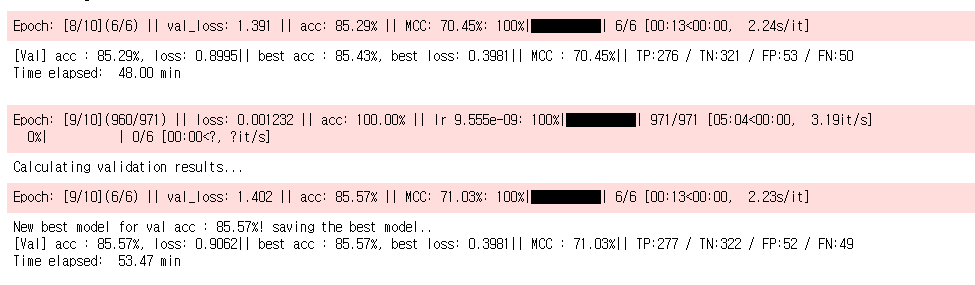

![]("./캡쳐.png")


# Inference

In [8]:
val_dataset = load_data("./data/SKT_BoolQ_Dev.tsv")

def inference(val_dataset,args, PATH):

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        
    config = getattr(import_module("transformers"), args.model_type + "Config").from_pretrained(args.pretrained_model)
    model_module = eval(args.model_type)
    model = model_module(config=config, args=args)
    model.load_state_dict(torch.load(PATH))
    model = model.to(device)
    
    model.eval()    
    tokenizer = AutoTokenizer.from_pretrained(args.pretrained_model)        
    val_label = val_dataset['label'].values
    
    global tokenized_sentences_d
    tokenized_val = tokenized_dataset(val_dataset, tokenizer, check_arch('Roberta'))
    val = CustomDataset(tokenized_val, val_label)    
    dataloader = DataLoader(val, batch_size=args.batch_size, shuffle=False, drop_last=False)

    labels = []
    preds = []
   
    for i, items in enumerate(tqdm(dataloader)):
        item = {key: val.to(device) for key, val in items.items()}
        with torch.no_grad():
            outputs = model(**item)
    
        logits = outputs[0]
        m = nn.Softmax(dim=1)
        logits = m(logits)
        pred = torch.argmax(logits, 1)
        
        pred = pred.detach().cpu().numpy().tolist()
        label = item['labels'].detach().cpu().numpy().tolist()
        
        preds += pred
        labels += label
        
    val_acc=accuracy_score(labels, preds)
    
    print('val')
    print('acc: %.4f'%(val_acc))

In [9]:
PATH = 'saved_model/판정의문문_0.855714.pt'
inference(val_dataset, args, PATH)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

val
acc: 0.8557
